Packages:

In [3]:
import glob
import os
import warnings


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# %pip install pydicom
import pydicom
from pydicom.data import get_testdata_files
from sklearn.model_selection import train_test_split

from IPython.display import Markdown, display

 # Import functions from the module
import importlib
import help_files._0_definitions 
import  help_files._1_visuals_script
# import  help_files._01_load_data
 # Reload the module to apply the changes to the script
importlib.reload(help_files._0_definitions)
importlib.reload(help_files._1_visuals_script)
# importlib.reload(help_files._01_load_data)
import  help_files._1_visuals_script  as pauls_vs
# Group by 'condition', 'level', and 'severity' and count occurrences
from help_files._0_definitions import count_severity_by_condition_level 
# Define the path
from pathlib import Path

pd.set_option("display.width", 1000)  # Set a large width to prevent line wrapping
 

In [273]:
### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_definitions.py") as file:
    exec(file.read())

In [274]:
# open dataframes of CSV files
dataframes = ["df_end"]
file_names = ["df_end.csv"]
 
# Load the data from _01_load_data
dataframes = [pd.read_csv(data_path_vor / file_name) for file_name in file_names]
df_end = dataframes[0]


In [275]:
df_end.dtypes

study_id        int64
severity      float64
condition       int64
level          object
series_id     float64
x             float64
y             float64
image_path     object
dtype: object

first try 

In [276]:
# Randomly sample 100 rows from random_samples_combined
random_samples_test_check = df_end.sample(n=100, random_state=RSEED)
random_samples_test_check


,study_id,severity,condition,level,series_id,x,y,image_path
1801,2543001868,1.0,0,l5/s1,7.878829e+08,282.233215,309.144876,data/train_images_origin/2543001868/1289783254...
1190,1698156042,2.0,0,l5/s1,1.349877e+09,178.912134,213.389121,data/train_images_origin/1698156042/3800217841...
1817,2568819355,0.0,0,l5/s1,6.402851e+08,360.224323,568.235013,data/train_images_origin/2568819355/4223104020...
251,358286753,2.0,0,l5/s1,1.392935e+09,133.461942,246.570393,data/train_images_origin/358286753/4144723093/...
2505,3515641631,1.0,0,l5/s1,3.168174e+09,408.250460,550.081594,data/train_images_origin/3515641631/4119560068...
...,...,...,...,...,...,...,...,...
416,607436629,0.0,0,l5/s1,4.274491e+09,208.310903,246.131231,data/train_images_origin/607436629/493360101/5...
2631,3742728457,0.0,0,l5/s1,2.064758e+09,169.131790,266.956346,data/train_images_origin/3742728457/4105399347...
2291,3239069834,1.0,0,l5/s1,2.276407e+09,233.190776,394.465409,data/train_images_origin/3239069834/2352610120...
174,286903519,0.0,0,l5/s1,1.527286e+09,229.419524,316.628781,data/train_images_origin/286903519/1921917205/...


Restore parameters and metrtics from mlflow

In [277]:
import mlflow
# %pip install torchsummary
from torchsummary import summary
import mlflow.pytorch

# Set the experiment name (optional, helps in identifying runs)
experiment_name = "Resnet50_MRI_Classification"
mlflow.set_experiment(experiment_name)

# Specify the run ID of the logged model
run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID

# Create the model URI
model_uri = f"runs:/{run_id}/model"

# Load the model
model = mlflow.pytorch.load_model(model_uri)

# Now you can use the model for inference or evaluation
model.eval()  # Set the model to evaluation mode
# Get all runs for the experiment
runs = mlflow.search_runs(experiment_names=[experiment_name])

print(runs.filter(like='params.').to_string(index=False))
# Display all metrics
metrics_columns = [col for col in runs.columns if col.startswith('metrics.')]
print(runs[metrics_columns].to_string(index=False))



params.pretrained_weights params.optimizer params.num_classes params.input_size                  params.model_architecture params.num_epochs params.activation_function params.learning_rate params.stop_threshold params.batch_size params.num_layers
            IMAGENET1K_V1             Adam                  3           224x224                                  ResNet-50                30                       ReLU               0.0001                   0.2                 4                10
            IMAGENET1K_V1             Adam                  3           224x224                                  ResNet-50                30                       ReLU               0.0001                   0.2                 4                10
            IMAGENET1K_V1             Adam                  3           224x224                                  ResNet-50                30                       ReLU               0.0001                   0.2                 4                10
            

In [278]:
# Display the model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Explanation of Each Column of Model

### Layer (type):
This column lists the name and type of each layer in the model. For example, `Conv2d` represents a 2D convolutional layer, `BatchNorm2d` represents a 2D batch normalization layer, `ReLU` represents a rectified linear unit activation function, and so on.

### Output Shape:
This column shows the shape of the output tensor from each layer. The shape is represented as `[-1, channels, height, width]`, where `-1` indicates a variable batch size, `channels` is the number of feature maps, and `height` and `width` are the spatial dimensions of the feature maps.

### Param #:
This column indicates the number of trainable parameters in each layer. Parameters include weights and biases that are learned during training.

## Detailed Breakdown of Some Layers

### Conv2d-1:
- **Type:** Conv2d
- **Output Shape:** `[-1, 64, 112, 112]`
- **Param #:** 9,408
- **Description:** This is the first convolutional layer with 64 filters, each of size 7x7, applied to the input image. The output feature maps have a spatial resolution of 112x112.

### BatchNorm2d-2:
- **Type:** BatchNorm2d
- **Output Shape:** `[-1, 64, 112, 112]`
- **Param #:** 128
- **Description:** This layer normalizes the output of the previous convolutional layer to improve training stability and performance.

### ReLU-3:
- **Type:** ReLU
- **Output Shape:** `[-1, 64, 112, 112]`
- **Param #:** 0
- **Description:** This layer applies the ReLU activation function, which introduces non-linearity to the model.

### MaxPool2d-4:
- **Type:** MaxPool2d
- **Output Shape:** `[-1, 64, 56, 56]`
- **Param #:** 0
- **Description:** This layer performs max pooling, reducing the spatial dimensions of the feature maps to 56x56.

### Conv2d-5:
- **Type:** Conv2d
- **Output Shape:** `[-1, 64, 56, 56]`
- **Param #:** 4,096
- **Description:** This is another convolutional layer with 64 filters, each of size 3x3, applied to the feature maps from the previous layer.

### BatchNorm2d-6:
- **Type:** BatchNorm2d
- **Output Shape:** `[-1, 64, 56, 56]`
- **Param #:** 128
- **Description:** This layer normalizes the output of the previous convolutional layer.

### ReLU-7:
- **Type:** ReLU
- **Output Shape:** `[-1, 64, 56, 56]`
- **Param #:** 0
- **Description:** This layer applies the ReLU activation function.

### Bottleneck-16:
- **Type:** Bottleneck
- **Output Shape:** `[-1, 256, 56, 56]`
- **Param #:** 0
- **Description:** This is a bottleneck block, which is a key component of ResNet architectures. It consists of multiple convolutional layers and skip connections.

#### Bottleneck-172
- **Type:** Bottleneck
- **Output Shape:** `[-1, 2048, 7, 7]`
- **Param #:** 0
- **Description:** This is a bottleneck block, which is a key component of ResNet architectures. It consists of multiple convolutional layers and skip connections.

#### AdaptiveAvgPool2d-173
- **Type:** AdaptiveAvgPool2d
- **Output Shape:** `[-1, 2048, 1, 1]`
- **Param #:** 0
- **Description:** This layer performs adaptive average pooling, reducing the spatial dimensions of the feature maps to 1x1 while maintaining the number of channels.

#### Linear-174
- **Type:** Linear
- **Output Shape:** `[-1, 3]`
- **Param #:** 6,147
- **Description:** This is a fully connected (dense) layer with 3 output units, typically used for classification tasks. The number of parameters includes the weights and biases.

## Summary of the Model

- **Total Parameters:** 23,514,179
- **Trainable Parameters:** 23,514,179
- **Non-trainable Parameters:** 0
- **Input Size (MB):** 0.57
- **Forward/Backward Pass Size (MB):** 286.55
- **Params Size (MB):** 89.70
- **Estimated Total Size (MB):** 376.82

## Explanation of the Summary

- **Total Parameters:** The total number of parameters in the model, including both trainable and non-trainable parameters.
- **Trainable Parameters:** The number of parameters that are updated during training.
- **Non-trainable Parameters:** The number of parameters that are not updated during training (e.g., fixed weights).
- **Input Size (MB):** The memory size of the input data.
- **Forward/Backward Pass Size (MB):** The memory size required for the forward and backward passes during training.
- **Params Size (MB):** The memory size of the model parameters.
- **Estimated Total Size (MB):** The estimated total memory size required for the model.

This detailed breakdown helps in understanding the architecture and complexity of the ResNet-like model, including the number of layers, their types, output shapes, and the number of parameters.

Transforming pretrained model: freezing layers and i# Set the model to evaluation mode
model.eval()ntroduce addtional ones

load parameters from previous model

In [279]:
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pydicom
import cv2
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 42  # You can choose any integer
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set up the experiment in MLflow
experiment_name = "Resnet50_MRI_Classification"
mlflow.set_experiment(experiment_name)

# Specify the run ID and load the model from MLflow
run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID
model_uri = f"runs:/{run_id}/model"

# Load the model
m_1 = mlflow.pytorch.load_model(model_uri)

# Verify the model is loaded correctly
print("Loaded Model:")
print(m_1)

Loaded Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

MRI transformation and loader settings

In [280]:
import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for setting the random seed

# Define the transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),  # Uncomment if you want to use horizontal flipping
    # transforms.RandomRotation(10),     # Uncomment if you want to use rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset class for loading MRI images
class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

        # Ensure severity is in integer format
        self.data['severity'] = self.data['severity'].astype(int)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = row['image_path']
        label = row['severity']  # Use severity for the label

        dicom_image = pydicom.dcmread(image_path)
        image = dicom_image.pixel_array.astype(float)
        image = (image / image.max() * 255).astype('uint8')  # Normalize

        # Convert the image to RGB if it is grayscale
        if len(image.shape) == 2:  # Grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Apply transformations including augmentation
        image_tensor = self.transform(image) if self.transform else torch.from_numpy(image).permute(2, 0, 1)

        return image_tensor, torch.tensor(label).long()  # Return label as tensor

    def __len__(self):
        return len(self.data)


Freezing layer and defining new one 

In [281]:
# df_end = random_samples_test_check

In [282]:
# Move the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_1.to(device)

# Freeze all layers of the loaded model
for param in m_1.parameters():
    param.requires_grad = False  # Freeze all parameters

# Modify the fully connected (fc) layer to match new requirements
m_1.fc = nn.Sequential(
    nn.Linear(m_1.fc.in_features, 512),  # Intermediate fully connected layer
    nn.ReLU(),                           # Activation function
    nn.Dropout(0.5),                     # Optional regularization with dropout
    nn.Linear(512, df_end['severity'].nunique())  # Final layer for classification
)

# Move the modified model to the appropriate device (GPU or CPU) again, in case of changes
m_1.to(device)

# Set up training dataset and DataLoaders  
dataset = MRIDataset(data=df_end, transform=transform)



Setting train and validation datasets: claculating metrics CrossEntropyLoss 

In [283]:
# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define loss functions and optimizer
criterion_cel = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(m_1.parameters(), lr=0.0001)
num_epochs = 30

# Lists to store loss values for plotting
train_losses_cel = []
val_losses_cel = []
train_losses_mse = []
val_losses_mse = []

# Early stopping parameters
stop_threshold = 0.2  # Threshold for validation loss to diverge from training loss
diverge_count = 0
max_diverge_count = 3  # Number of epochs validation loss is allowed to diverge



introduce all mlflow log parameters see _1_1_1_model

setting mlflow: end running new model

In [285]:
# Start MLflow run
with mlflow.start_run(nested=True):
    # Log parameters
    mlflow.log_param("learning_rate", 0.0001)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", 4)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("model_architecture", "Modified ResNet-50")
    mlflow.log_param("input_size", "224x224")
    mlflow.log_param("num_classes", df_end['severity'].nunique())

    # Training and validation loop
    for epoch in range(num_epochs):
        # Training phase
        m_1.train()
        running_loss_cel_train = 0.0
        running_loss_mse_train = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = m_1(images)
            
            # Cross Entropy Loss
            loss_cel = criterion_cel(outputs, labels)
            running_loss_cel_train += loss_cel.item()

            # MSE Loss (if applicable)
            mse_target = labels.float().unsqueeze(1).expand_as(outputs)  # Ensure shape matches
            loss_mse = criterion_mse(outputs, mse_target)
            running_loss_mse_train += loss_mse.item()
            
            # Backward pass and optimization
            loss_cel.backward()
            optimizer.step()

        # Calculate average losses
        epoch_loss_cel_train = running_loss_cel_train / len(train_loader)
        train_losses_cel.append(epoch_loss_cel_train)
        epoch_loss_mse_train = running_loss_mse_train / len(train_loader)
        train_losses_mse.append(epoch_loss_mse_train)

        # Log training losses to MLflow
        mlflow.log_metric("train_loss_cel", epoch_loss_cel_train, step=epoch)
        mlflow.log_metric("train_loss_mse", epoch_loss_mse_train, step=epoch)

        # Validation phase
        m_1.eval()
        running_loss_cel_val = 0.0
        running_loss_mse_val = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = m_1(images)
                
                # Cross Entropy Loss for validation
                loss_cel = criterion_cel(outputs, labels)
                running_loss_cel_val += loss_cel.item()
                
                # MSE Loss (if applicable)
                mse_target = labels.float().unsqueeze(1).expand_as(outputs)  # Ensure shape matches
                loss_mse = criterion_mse(outputs, mse_target)
                running_loss_mse_val += loss_mse.item()

        # Calculate validation losses
        epoch_loss_cel_val = running_loss_cel_val / len(val_loader)
        val_losses_cel.append(epoch_loss_cel_val)
        epoch_loss_mse_val = running_loss_mse_val / len(val_loader)
        val_losses_mse.append(epoch_loss_mse_val)

        # Log validation losses to MLflow
        mlflow.log_metric("val_loss_cel", epoch_loss_cel_val, step=epoch)
        mlflow.log_metric("val_loss_mse", epoch_loss_mse_val, step=epoch)

        # Early stopping check
        if epoch_loss_cel_val > epoch_loss_cel_train * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch+1} due to validation loss diverging.")
                break
        else:
            diverge_count = 0  # Reset count if validation loss improves

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Cross Entropy Loss: {epoch_loss_cel_train:.4f}, '
              f'Validation Cross Entropy Loss: {epoch_loss_cel_val:.4f}')

    print("Training complete!")

    # Log the model
    mlflow.pytorch.log_model(m_1, "modified_model")

    # passing to mlflow
   # Plot and log the loss curves as artifacts a
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_cel, label='Train Cross Entropy Loss')
    plt.plot(val_losses_cel, label='Validation Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Cross Entropy Loss')
    plt.legend()
    plt.savefig("cross_entropy_loss.png")
    mlflow.log_artifact("cross_entropy_loss.png")

    # Plot MSE Loss if applicable
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_mse, label='Train MSE Loss')
    plt.plot(val_losses_mse, label='Validation MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation MSE Loss')
    plt.legend()
    plt.savefig("mse_loss.png")
    mlflow.log_artifact("mse_loss.png")



KeyboardInterrupt: 

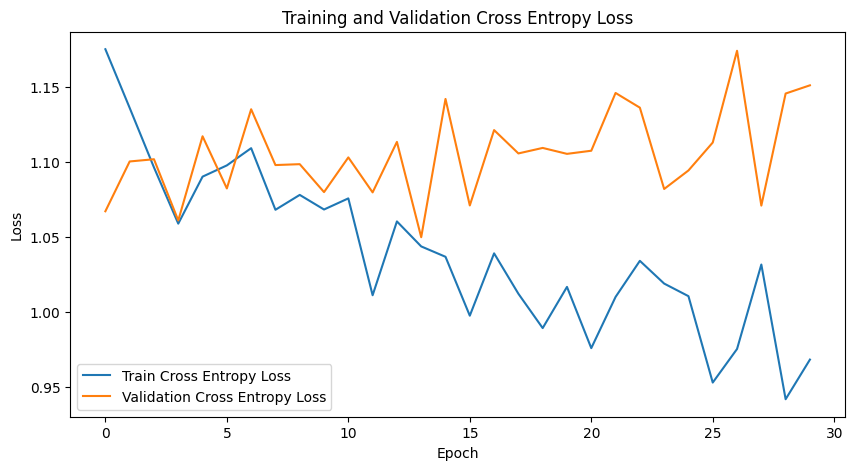

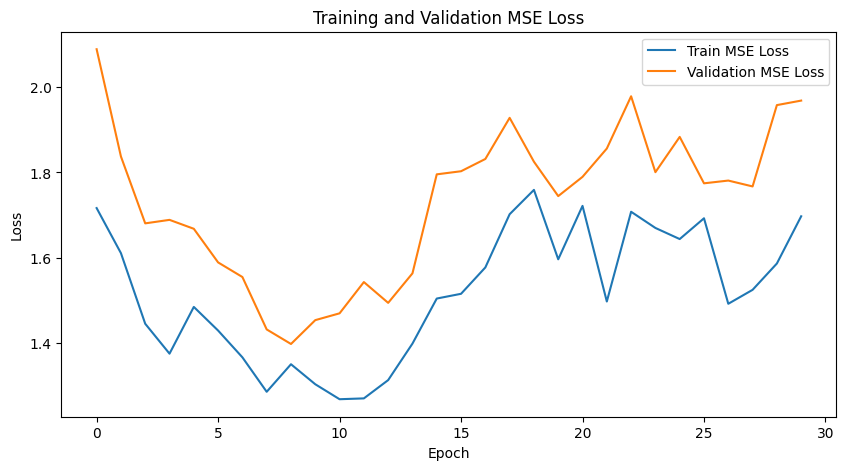

In [228]:
# Plot and log the loss curves as artifacts
plt.figure(figsize=(10, 5))
plt.plot(train_losses_cel, label='Train Cross Entropy Loss')
plt.plot(val_losses_cel, label='Validation Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Cross Entropy Loss')
plt.legend()
plt.savefig("cross_entropy_loss.png")
mlflow.log_artifact("cross_entropy_loss.png")
# Plot MSE Loss if applicable
plt.figure(figsize=(10, 5))
plt.plot(train_losses_mse, label='Train MSE Loss')
plt.plot(val_losses_mse, label='Validation MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.savefig("mse_loss.png")
 


In [230]:
# Count how many layers are frozen
frozen_layers_count = sum(1 for param in m_1.parameters() if not param.requires_grad)

# Get total number of layers (parameters)
total_layers_count = sum(1 for _ in m_1.parameters())

print(f"Frozen layers: {frozen_layers_count}/{total_layers_count} ({(frozen_layers_count / total_layers_count) * 100:.2f}%)")


Frozen layers: 159/163 (97.55%)


In [231]:
# Print the status of each layer
for name, param in m_1.named_parameters():
    if not param.requires_grad:
        print(f"Layer '{name}' is frozen.")
    else:
        print(f"Layer '{name}' is trainable.")

Layer 'conv1.weight' is frozen.
Layer 'bn1.weight' is frozen.
Layer 'bn1.bias' is frozen.
Layer 'layer1.0.conv1.weight' is frozen.
Layer 'layer1.0.bn1.weight' is frozen.
Layer 'layer1.0.bn1.bias' is frozen.
Layer 'layer1.0.conv2.weight' is frozen.
Layer 'layer1.0.bn2.weight' is frozen.
Layer 'layer1.0.bn2.bias' is frozen.
Layer 'layer1.0.conv3.weight' is frozen.
Layer 'layer1.0.bn3.weight' is frozen.
Layer 'layer1.0.bn3.bias' is frozen.
Layer 'layer1.0.downsample.0.weight' is frozen.
Layer 'layer1.0.downsample.1.weight' is frozen.
Layer 'layer1.0.downsample.1.bias' is frozen.
Layer 'layer1.1.conv1.weight' is frozen.
Layer 'layer1.1.bn1.weight' is frozen.
Layer 'layer1.1.bn1.bias' is frozen.
Layer 'layer1.1.conv2.weight' is frozen.
Layer 'layer1.1.bn2.weight' is frozen.
Layer 'layer1.1.bn2.bias' is frozen.
Layer 'layer1.1.conv3.weight' is frozen.
Layer 'layer1.1.bn3.weight' is frozen.
Layer 'layer1.1.bn3.bias' is frozen.
Layer 'layer1.2.conv1.weight' is frozen.
Layer 'layer1.2.bn1.weigh

In [229]:
s

NameError: name 's' is not defined

Loaded Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

c:\Users\HP1\Desktop\Spiced\capstone-project\.venv\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\HP1\Desktop\Spiced\capstone-project\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


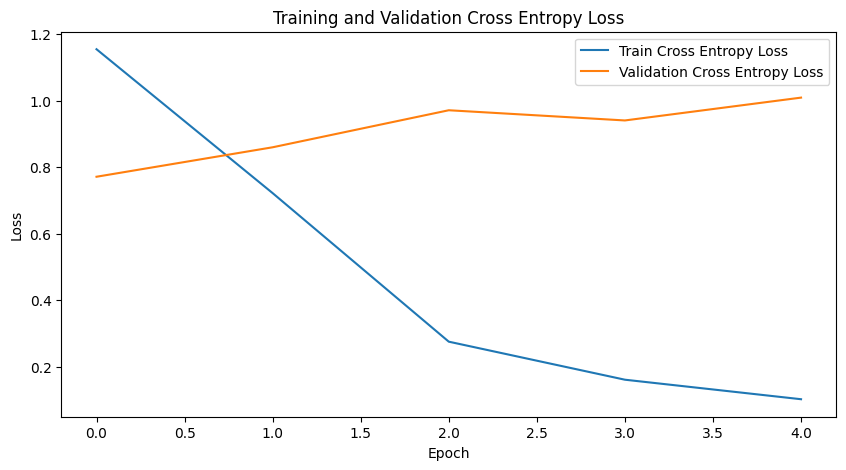

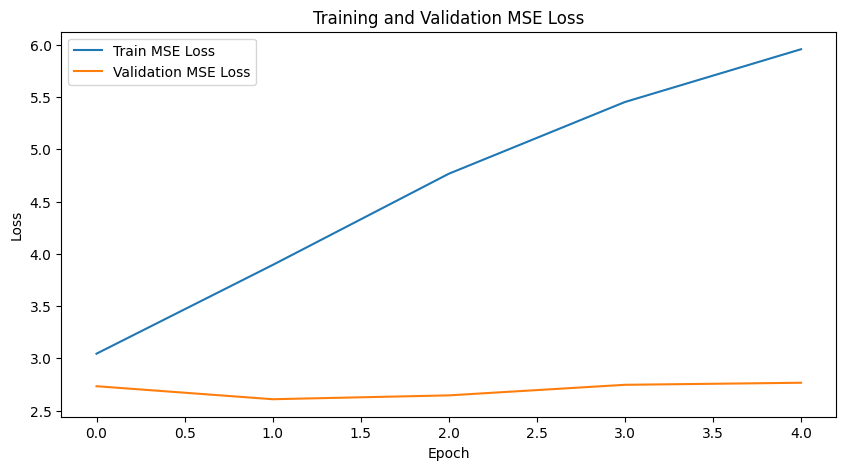

In [112]:
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset, random_split
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

# Set random seed for reproducibility
seed = 42  # You can choose any integer
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Define the transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),  # Uncomment if you want to use horizontal flipping
    # transforms.RandomRotation(10),     # Uncomment if you want to use rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ensure your dataset uses this transform
class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

        # Ensure severity is in integer format
        self.data['severity'] = self.data['severity'].astype(int)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = row['image_path']
        label = row['severity']  # Use severity for the label

        dicom_image = pydicom.dcmread(image_path)
        image = dicom_image.pixel_array.astype(float)
        image = (image / image.max() * 255).astype('uint8')  # Normalize

        # Convert the image to RGB if it is grayscale
        if len(image.shape) == 2:  # Grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Apply transformations including augmentation
        image_tensor = self.transform(image) if self.transform else torch.from_numpy(image).permute(2, 0, 1)

        return image_tensor, torch.tensor(label).long()  # Return label as tensor

    def __len__(self):
        return len(self.data)

# Set up the experiment in MLflow
experiment_name = "Resnet50_MRI_Classification"
mlflow.set_experiment(experiment_name)

# Specify the run ID and load the model from MLflow
run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID
model_uri = f"runs:/{run_id}/model"

# Load the model
m_1 = mlflow.pytorch.load_model(model_uri)

# Verify the model is loaded correctly
print("Loaded Model:")
print(m_1)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_1.to(device)

# Create the dataset with transformations
dataset = MRIDataset(data=random_samples_test_check, transform=transform)

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define loss functions and optimizer
criterion_cel = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(m_1.parameters(), lr=0.0001)
num_epochs = 30

# Lists to store loss values for plotting
train_losses_cel = []
val_losses_cel = []
train_losses_mse = []
val_losses_mse = []

# Early stopping parameters
stop_threshold = 0.2  # Threshold for validation loss to diverge from training loss
diverge_count = 0
max_diverge_count = 3  # Number of epochs validation loss is allowed to diverge

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("learning_rate", 0.0001)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", 4)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("model_architecture", "Modified ResNet-50")
    mlflow.log_param("input_size", "224x224")
    mlflow.log_param("num_classes", df_end['severity'].nunique())

    # Training and validation loop
    for epoch in range(num_epochs):
        # Training phase
        m_1.train()
        running_loss_cel_train = 0.0
        running_loss_mse_train = 0.0
        
        for images, labels in train_loader:
            if images is None or images.size(0) == 0:
                continue
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = m_1(images)
            
            # Cross Entropy Loss
            loss_cel = criterion_cel(outputs, labels)
            running_loss_cel_train += loss_cel.item()

            # MSE Loss (if applicable)
            mse_target = labels.float().unsqueeze(1).expand_as(outputs)  # Ensure shape matches
            loss_mse = criterion_mse(outputs, mse_target)
            running_loss_mse_train += loss_mse.item()
            
            # Backward pass and optimization
            loss_cel.backward()
            optimizer.step()

        # Calculate average losses
        epoch_loss_cel_train = running_loss_cel_train / len(train_loader)
        train_losses_cel.append(epoch_loss_cel_train)
        epoch_loss_mse_train = running_loss_mse_train / len(train_loader)
        train_losses_mse.append(epoch_loss_mse_train)

        # Log training losses to MLflow
        mlflow.log_metric("train_loss_cel", epoch_loss_cel_train, step=epoch)
        mlflow.log_metric("train_loss_mse", epoch_loss_mse_train, step=epoch)

        # Validation phase
        m_1.eval()
        running_loss_cel_val = 0.0
        running_loss_mse_val = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = m_1(images)
                
                # Cross Entropy Loss for validation
                loss_cel = criterion_cel(outputs, labels)
                running_loss_cel_val += loss_cel.item()
                
                # MSE Loss (if applicable)
                mse_target = labels.float().unsqueeze(1).expand_as(outputs)  # Ensure shape matches
                loss_mse = criterion_mse(outputs, mse_target)
                running_loss_mse_val += loss_mse.item()

        # Calculate validation losses
        epoch_loss_cel_val = running_loss_cel_val / len(val_loader)
        val_losses_cel.append(epoch_loss_cel_val)
        epoch_loss_mse_val = running_loss_mse_val / len(val_loader)
        val_losses_mse.append(epoch_loss_mse_val)

        # Log validation losses to MLflow
        mlflow.log_metric("val_loss_cel", epoch_loss_cel_val, step=epoch)
        mlflow.log_metric("val_loss_mse", epoch_loss_mse_val, step=epoch)

        # Early stopping check
        if epoch_loss_cel_val > epoch_loss_cel_train * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch+1} due to validation loss diverging.")
                break
        else:
            diverge_count = 0  # Reset count if validation loss improves

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Cross Entropy Loss: {epoch_loss_cel_train:.4f}, '
              f'Validation Cross Entropy Loss: {epoch_loss_cel_val:.4f}')

    print("Training complete!")

    # Log the model
    mlflow.pytorch.log_model(m_1, "modified_model")

    # Plot and log the loss curves as artifacts
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_cel, label='Train Cross Entropy Loss')
    plt.plot(val_losses_cel, label='Validation Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Cross Entropy Loss')
    plt.legend()
    plt.savefig("cross_entropy_loss.png")
    mlflow.log_artifact("cross_entropy_loss.png")

    # Plot MSE Loss if applicable
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_mse, label='Train MSE Loss')
    plt.plot(val_losses_mse, label='Validation MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation MSE Loss')
    plt.legend()
    plt.savefig("mse_loss.png")
    mlflow.log_artifact("mse_loss.png")


In [ ]:
s

In [ ]:
s

In [77]:
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Set up the experiment name and load the existing model
experiment_name = "Resnet50_MRI_Classification"
mlflow.set_experiment(experiment_name)

# Specify the run ID of the previously logged model
run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID

# Create the model URI
model_uri = f"runs:/{run_id}/model"

# Load the original model from MLflow
m_1 = mlflow.pytorch.load_model(model_uri)

# Verify that the original model is loaded correctly
print("Original Model Loaded:")
print(m_1)

# Freeze all layers of the loaded model
for param in m_1.parameters():
    param.requires_grad = False  # Freeze all parameters

# Modify the fully connected (fc) layer to match new requirements
m_1.fc = nn.Sequential(
    nn.Linear(m_1.fc.in_features, 512),  # Intermediate fully connected layer
    nn.ReLU(),                           # Activation function
    nn.Dropout(0.5),                     # Optional regularization with dropout
    nn.Linear(512, m_1.fc.out_features)  # Final layer for classification
)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_1.to(device)

# Print the modified model architecture to verify changes
print("Modified Model Architecture:")
print(m_1)

# Log the new modified model in MLflow
with mlflow.start_run():
    mlflow.log_param("model_architecture", "Modified ResNet-50 based on original model")
    mlflow.pytorch.log_model(m_1, "modified_model")

print("New modified model logged successfully.")


Original Model Loaded:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_s

c:\Users\HP1\Desktop\Spiced\capstone-project\.venv\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\HP1\Desktop\Spiced\capstone-project\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Loaded Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

c:\Users\HP1\Desktop\Spiced\capstone-project\.venv\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\HP1\Desktop\Spiced\capstone-project\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


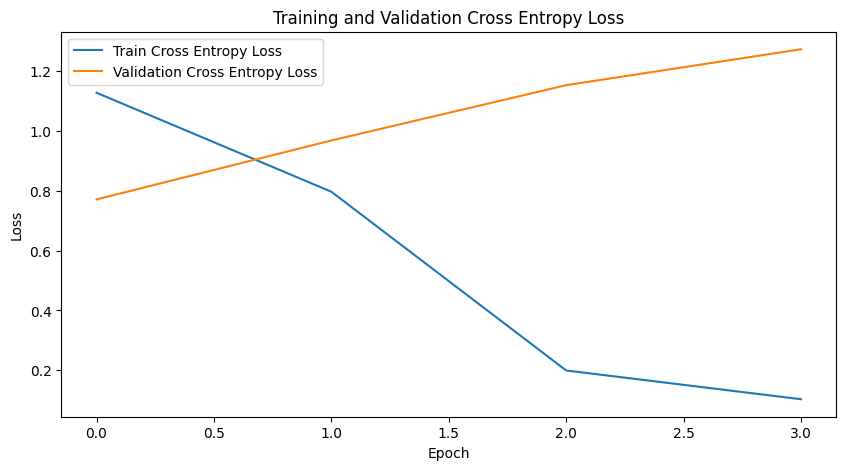

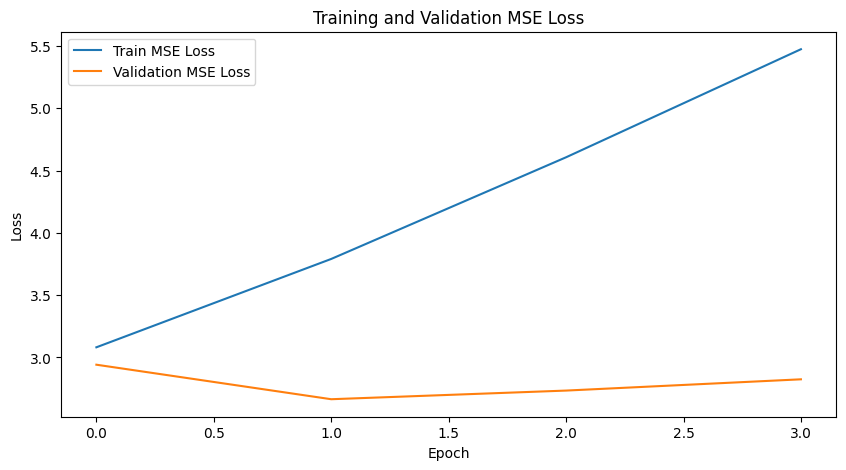

In [78]:
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 42  # You can choose any integer
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set up the experiment in MLflow
experiment_name = "Resnet50_MRI_Classification"
mlflow.set_experiment(experiment_name)

# Specify the run ID and load the model from MLflow
run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID
model_uri = f"runs:/{run_id}/model"

# Load the model
m_1 = mlflow.pytorch.load_model(model_uri)

# Verify the model is loaded correctly
print("Loaded Model:")
print(m_1)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_1.to(device)

# Set up dataset and DataLoaders (assume MRIDataset and transform are defined)
dataset = MRIDataset(data=random_samples_test_check, transform=transform)

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define loss functions and optimizer
criterion_cel = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(m_1.parameters(), lr=0.0001)
num_epochs = 30

# Lists to store loss values for plotting
train_losses_cel = []
val_losses_cel = []
train_losses_mse = []
val_losses_mse = []

# Early stopping parameters
stop_threshold = 0.2  # Threshold for validation loss to diverge from training loss
diverge_count = 0
max_diverge_count = 3  # Number of epochs validation loss is allowed to diverge

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("learning_rate", 0.0001)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", 4)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("model_architecture", "Modified ResNet-50")
    mlflow.log_param("input_size", "224x224")
    mlflow.log_param("num_classes", df_end['severity'].nunique())

    # Training and validation loop
    for epoch in range(num_epochs):
        # Training phase
        m_1.train()
        running_loss_cel_train = 0.0
        running_loss_mse_train = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = m_1(images)
            
            # Cross Entropy Loss
            loss_cel = criterion_cel(outputs, labels)
            running_loss_cel_train += loss_cel.item()

            # MSE Loss (if applicable)
            mse_target = labels.float().unsqueeze(1).expand_as(outputs)  # Ensure shape matches
            loss_mse = criterion_mse(outputs, mse_target)
            running_loss_mse_train += loss_mse.item()
            
            # Backward pass and optimization
            loss_cel.backward()
            optimizer.step()

        # Calculate average losses
        epoch_loss_cel_train = running_loss_cel_train / len(train_loader)
        train_losses_cel.append(epoch_loss_cel_train)
        epoch_loss_mse_train = running_loss_mse_train / len(train_loader)
        train_losses_mse.append(epoch_loss_mse_train)

        # Log training losses to MLflow
        mlflow.log_metric("train_loss_cel", epoch_loss_cel_train, step=epoch)
        mlflow.log_metric("train_loss_mse", epoch_loss_mse_train, step=epoch)

        # Validation phase
        m_1.eval()
        running_loss_cel_val = 0.0
        running_loss_mse_val = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = m_1(images)
                
                # Cross Entropy Loss for validation
                loss_cel = criterion_cel(outputs, labels)
                running_loss_cel_val += loss_cel.item()
                
                # MSE Loss (if applicable)
                mse_target = labels.float().unsqueeze(1).expand_as(outputs)  # Ensure shape matches
                loss_mse = criterion_mse(outputs, mse_target)
                running_loss_mse_val += loss_mse.item()

        # Calculate validation losses
        epoch_loss_cel_val = running_loss_cel_val / len(val_loader)
        val_losses_cel.append(epoch_loss_cel_val)
        epoch_loss_mse_val = running_loss_mse_val / len(val_loader)
        val_losses_mse.append(epoch_loss_mse_val)

        # Log validation losses to MLflow
        mlflow.log_metric("val_loss_cel", epoch_loss_cel_val, step=epoch)
        mlflow.log_metric("val_loss_mse", epoch_loss_mse_val, step=epoch)

        # Early stopping check
        if epoch_loss_cel_val > epoch_loss_cel_train * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch+1} due to validation loss diverging.")
                break
        else:
            diverge_count = 0  # Reset count if validation loss improves

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Cross Entropy Loss: {epoch_loss_cel_train:.4f}, '
              f'Validation Cross Entropy Loss: {epoch_loss_cel_val:.4f}')

    print("Training complete!")

    # Log the model
    mlflow.pytorch.log_model(m_1, "modified_model")

    # Plot and log the loss curves as artifacts
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_cel, label='Train Cross Entropy Loss')
    plt.plot(val_losses_cel, label='Validation Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Cross Entropy Loss')
    plt.legend()
    plt.savefig("cross_entropy_loss.png")
    mlflow.log_artifact("cross_entropy_loss.png")

    # Plot MSE Loss if applicable
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_mse, label='Train MSE Loss')
    plt.plot(val_losses_mse, label='Validation MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation MSE Loss')
    plt.legend()
    plt.savefig("mse_loss.png")
    mlflow.log_artifact("mse_loss.png")


In [79]:
# Display the model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [80]:
import mlflow
import mlflow.pytorch
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pydicom
import cv2
import pandas as pd

# Assuming random_samples_test_check is your test dataset DataFrame
test_data = random_samples_test_check

# Define your dataset class if not defined yet
class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.data['severity'] = self.data['severity'].astype(int)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = row['image_path']
        label = row['severity']
        dicom_image = pydicom.dcmread(image_path)
        image = dicom_image.pixel_array.astype(float)
        image = (image / image.max() * 255).astype('uint8')
        if len(image.shape) == 2:  # Convert grayscale to RGB
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image_tensor = self.transform(image) if self.transform else torch.from_numpy(image).permute(2, 0, 1)
        return image_tensor, torch.tensor(label).long()

    def __len__(self):
        return len(self.data)

# Transform for test pk
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_data = random_samples_test_check
# Create the test dataset and DataLoader
test_dataset = MRIDataset(data=random_samples_test_check, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the model
experiment_name = "Resnet50_MRI_Classification"
mlflow.set_experiment(experiment_name)

run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID
model_uri = f"runs:/{run_id}/model"

model = mlflow.pytorch.load_model(model_uri)
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))  # Move model to the appropriate device
model.eval()  # Set the model to evaluation mode

# Inference loop with probability extraction
results = []
probabilities_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        labels = labels.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))  # Ensure labels are also on the correct device
        
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Calculate class probabilities
        _, predicted_classes = torch.max(outputs, 1)

        # Append predictions and probabilities
        results.append(predicted_classes.item())
        probabilities_list.append(probabilities.cpu().numpy())

# Convert results and probabilities to DataFrame for easier handling
results_df = pd.DataFrame(results, columns=['Predicted_Class'])
probabilities_df = pd.DataFrame(np.vstack(probabilities_list), columns=[f'Class_{i}' for i in range(probabilities.shape[1])])

# Combine predictions and probabilities
final_results = pd.concat([results_df, probabilities_df], axis=1)

# Save results to a CSV file
final_results.to_csv("test_predictions.csv", index=False)

# print("Predictions and probabilities have been saved to test_predictions.csv.")


In [81]:
test_data = random_samples_test_check

test_dataset = MRIDataset(data=test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Inference loop with probability extraction
results = []
probabilities_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Calculate class probabilities
        _, predicted_classes = torch.max(outputs, 1)
        
        # Append predictions and probabilities
        results.append(predicted_classes.item())
        probabilities_list.append(probabilities.cpu().numpy())



Using device: cpu


In [82]:
# Print predicted classes and their probabilities
for i, (pred, probs) in enumerate(zip(results, probabilities_list)):
    print(f"Test image {i}: Predicted class {pred}, Probabilities: {probs}")

# Additional code to plot the confusion matrix can stay as-is:
true_labels = []
predicted_labels = []

for images, labels in test_loader:
    images = images.to(device)
    true_labels.extend(labels.numpy())

    with torch.no_grad():
        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)
        predicted_labels.extend(predicted_classes.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

print("True Labels Unique Values:", np.unique(true_labels))
print("Predicted Labels Unique Values:", np.unique(predicted_labels))


Test image 0: Predicted class 2, Probabilities: [[0.11478617 0.40704674 0.47816712]]
Test image 1: Predicted class 2, Probabilities: [[0.25198954 0.23506203 0.5129484 ]]
Test image 2: Predicted class 2, Probabilities: [[0.2526974  0.27864584 0.4686568 ]]
Test image 3: Predicted class 2, Probabilities: [[0.19084536 0.33588043 0.4732742 ]]
Test image 4: Predicted class 0, Probabilities: [[0.38362142 0.24373426 0.37264434]]
Test image 5: Predicted class 2, Probabilities: [[0.11193226 0.39257464 0.49549305]]
Test image 6: Predicted class 2, Probabilities: [[0.06976385 0.46457228 0.46566388]]
Test image 7: Predicted class 2, Probabilities: [[0.03366886 0.29567865 0.6706525 ]]
Test image 8: Predicted class 2, Probabilities: [[0.12838626 0.24508195 0.6265318 ]]
Test image 9: Predicted class 2, Probabilities: [[0.12029517 0.2444862  0.6352186 ]]
True Labels Unique Values: [1 2]
Predicted Labels Unique Values: [0 2]


In [83]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(
    conf_matrix, 
    index=[f"Actual {i}" for i in range(len(conf_matrix))], 
    columns=[f"Predicted {i}" for i in range(len(conf_matrix[0]))]
)

# Print the confusion matrix DataFrame
print(conf_matrix_df)

# Optionally, display it using a more formatted view (e.g., in Jupyter Notebook)
conf_matrix_df.style.background_gradient(cmap='Blues')


          Predicted 0  Predicted 1  Predicted 2
Actual 0            0            0            0
Actual 1            1            0            3
Actual 2            0            0            6


,Predicted 0,Predicted 1,Predicted 2
Actual 0,0,0,0
Actual 1,1,0,3
Actual 2,0,0,6


In [87]:
# Convert the list of probabilities to a numpy array for easier manipulation
probabilities_array = np.vstack(probabilities_list)

# Calculate the average probability for each class
average_probabilities = np.mean(probabilities_array, axis=0)

# Print the average probabilities
for i, avg_prob in enumerate(average_probabilities):
    print(f"Average probability for class {i}: {avg_prob:.4f}")

Average probability for class 0: 0.1658
Average probability for class 1: 0.3143
Average probability for class 2: 0.5199
